In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_h1 = pd.read_csv('./dataset/H1.csv')
df_h2 = pd.read_csv('./dataset/H2.csv')

# Initial data exploration
print("H1 Dataset Shape: ", df_h1.shape)
print("H2 Dataset Shape: ", df_h2.shape)

df_h1['Hotel'] = 'H1'
df_h2['Hotel'] = 'H2'
df = pd.concat([df_h1, df_h2])
print("Combined Dataset Shape: ", df.shape)
df.head()

H1 Dataset Shape:  (40060, 31)
H2 Dataset Shape:  (79330, 31)
Combined Dataset Shape:  (119390, 32)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Hotel
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,H1
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,H1
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1


In [25]:
nan_replacements = {"Children:": 0.0,"Country": "Unknown", "Agent": 0, "Company": 0}
df = df.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
df["Meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# I'm dropping these entries with no guests.
zero_guests = list(df.loc[df["Adults"]
                   + df["Children"]
                   + df["Babies"]==0].index)
df.drop(df.index[zero_guests], inplace=True)

/var/folders/cr/n708zkvn3yl95rky5npx_kzw0000gn/T/ipykernel_95277/402215954.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Meal"].replace("Undefined", "SC", inplace=True)


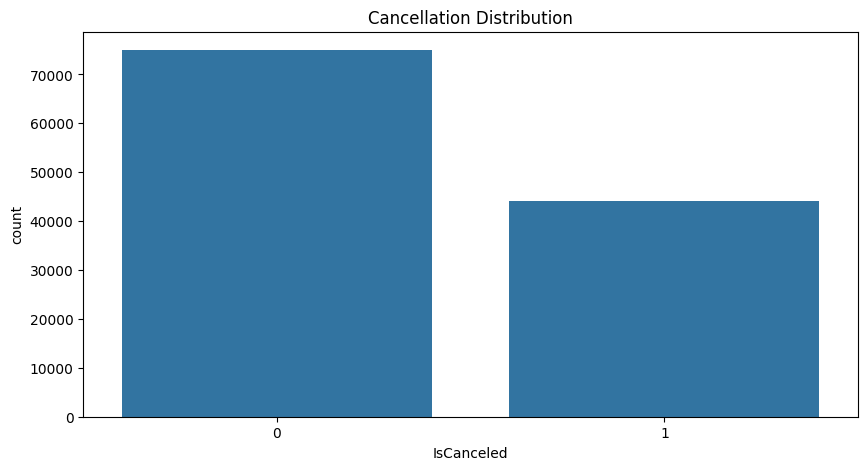

In [26]:
# Visualizing target variable (IsCanceled) distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='IsCanceled', data=df)
plt.title("Cancellation Distribution")
plt.show()

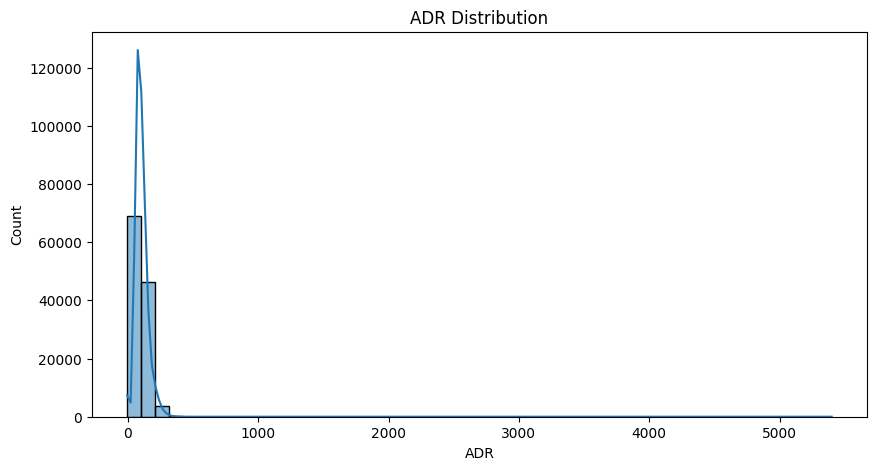

In [27]:
# Feature 1: ADR (Average Daily Rate)
plt.figure(figsize=(10, 5))
sns.histplot(df['ADR'], bins=50, kde=True)
plt.title("ADR Distribution")
plt.show()

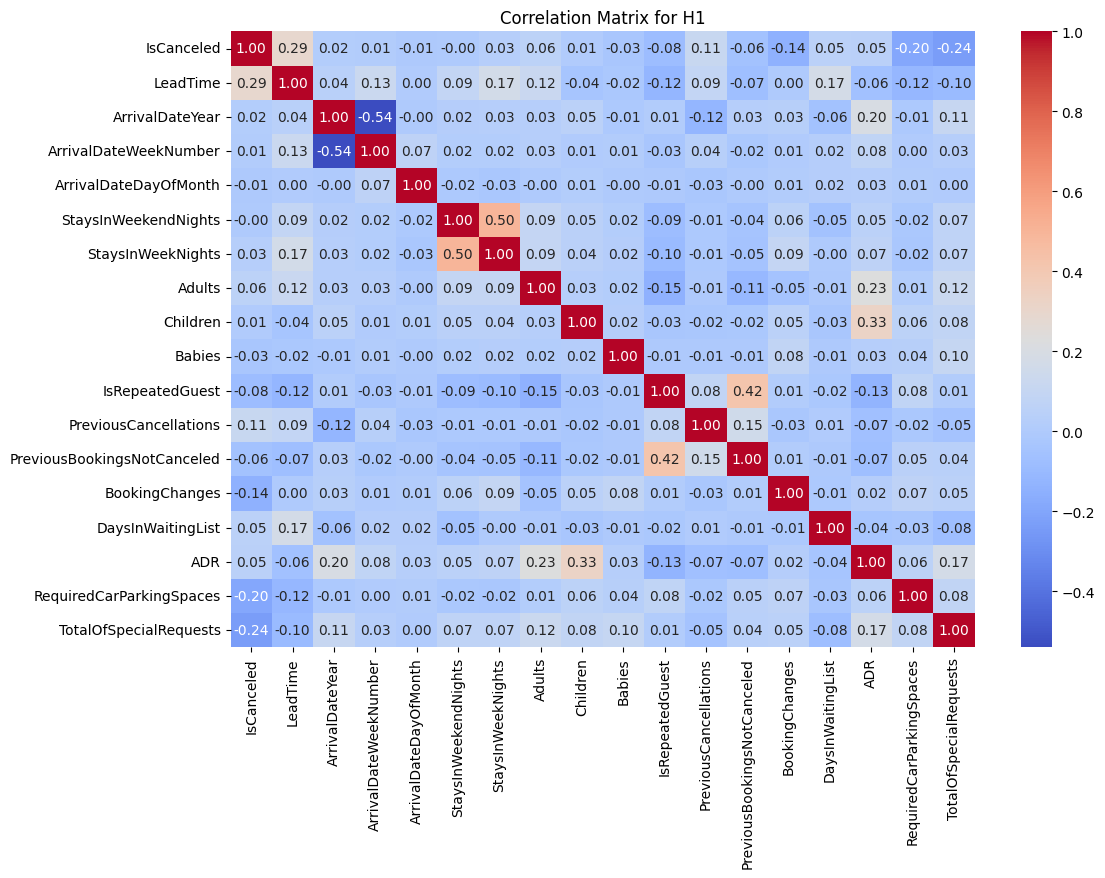

In [28]:
# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number])

# Correlation Matrix for H1
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix for H1")
plt.show()

<hr>

ValueError: cannot reindex on an axis with duplicate labels

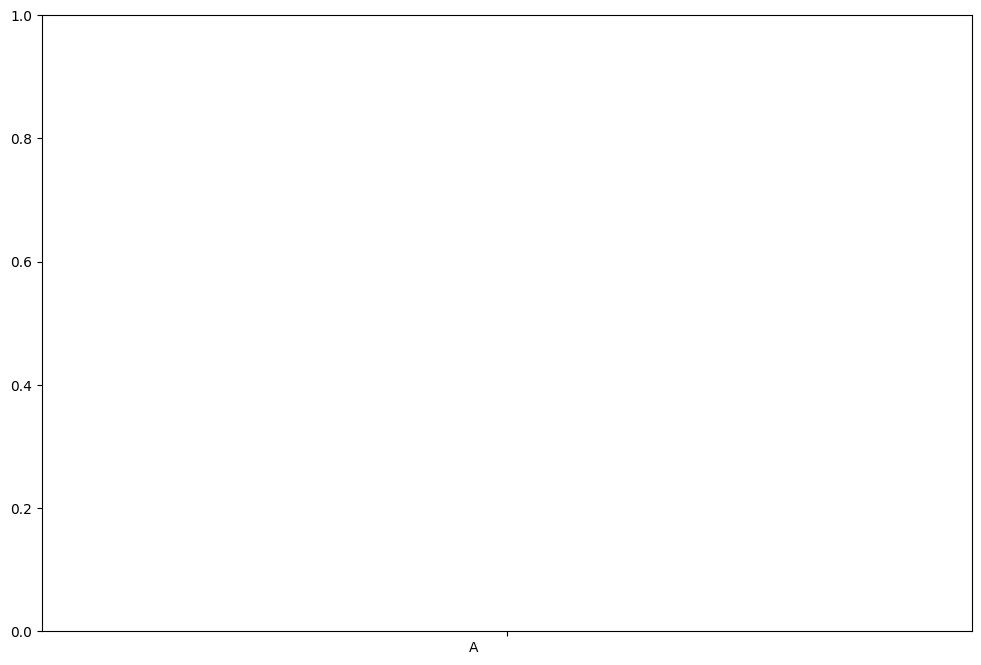

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have a DataFrame with the relevant data
# Creating the ADR per person feature
df["ADR_PP"] = df["ADR"] / (df["Adults"] + df["Children"] + df["Babies"])

# Filter guests with non-canceled bookings
data_guests = df.loc[df["IsCanceled"] == 0]

# Select relevant columns and sort by ReservedRoomType
room_prices = data_guests[["Hotel", "ReservedRoomType", "ADR_PP"]].sort_values("ReservedRoomType")

# Plot the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x="ReservedRoomType",
            y="ADR_PP",
            hue="Hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)  # Set the y-limit to the range shown in your image
plt.show()

